# Predicting Q3 grades using Portuguese school grades datasets

## Overview

Analyze student data and create a machine learning model to predict third term student performance. The primary goal is to predict G3 grades without using grades from the first two semesters (G1 and G2). 

The grading scale in the dataset is 0-20 with 20 being the highest score and 0 the lowest.

I use Sci-kit Learn to make Linear Regression, SVM Regression, Lasso Regression, Ridge Regression, Random Forest Regression, and stacking ensemble method.

Datasets were downloaded from the UC Irvine Machine Learning Repository: https://archive.ics.uci.edu/dataset/320/student+performance

## Getting the Data, Importing Packages

In [1]:
# importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error

from mpl_toolkits.mplot3d import Axes3D
from pandas.plotting import scatter_matrix

In [2]:
students = pd.read_csv("student-mat.csv", sep=';', usecols = ['goout','failures','traveltime','Fedu','Medu','age','G1','G2','G3',
                                                              'Mjob','sex','address','paid','higher','romantic','Walc',
                                                              'Dalc','freetime','internet','studytime','school','reason']) 
#read in CSV with necessary columns

In [3]:
G3_grade = students["G3"] #separate target values
students_1 = students.drop(columns=["G3"])

In [4]:
#splitting data into training and testing
X_train, X_test, y_train, y_test = train_test_split(students_1, G3_grade, test_size=0.2, random_state=42)

## Data Preparation

### Feature Selection
Listing out columns for the transformers into:
- **numeric_columns**
- **categorical_columns**
- **ordinal_columns**
### Creating Custom Pipelines and Transformers

In [5]:
from mat_cleaning import cleaning

In [6]:
# using fit_transform to transform the X_train data with and without G1 and G2 data

X_train_transformed_with_grades = cleaning.column_transformer_with_grades.fit_transform(X_train)

In [7]:
X_train_transformed_without_grades = cleaning.column_transformer_without_grades.fit_transform(X_train)

In [10]:
# This might side step my issues!
stacking_model_without = pickle.load(open('stackingwithout.pkl', 'rb'))
stacking_model_with = pickle.load(open('stackingwith.pkl', 'rb'))

In [12]:
# stacking Cross-Validation

cv_scores_stacking_model_with_grades = -cross_val_score(stacking_model_with, X_train_transformed_with_grades, y_train,
                                                        scoring="neg_root_mean_squared_error", cv=10)
cv_scores_stacking_model_without_grades = -cross_val_score(stacking_model_without, X_train_transformed_without_grades, y_train,
                                                           scoring="neg_root_mean_squared_error", cv=10)

In [13]:
CV_stacking_model_with_grades = cv_scores_stacking_model_with_grades.mean()
print(CV_stacking_model_with_grades)

CV_stacking_model_without_grades = cv_scores_stacking_model_without_grades.mean()
print(CV_stacking_model_without_grades)

1.8568448955709176
4.270776769268897


Since the pickle method works, I could delete the rest of this notebook and just import the model... The function in the next cell is a problem.

## Regression Models
I run 6 regression models:
- Linear Regression
- Support Vector Machine (SVM) Regression
- Lasso Regression
- Ridge Regression
- Random Forest Regression
- Stacking Ensemble Method

I then examine each of them with cross-validation (10 folds) and look at the root mean squared (RMSE) value to see which ones are closer to the target values.

### Linear Regression

### Stacked Ensemble Method

In [15]:
def linreg_model(lin_reg):
    lin_reg = LinearRegression()
    lin_reg.fit(X_train_transformed_with_grades, y_train)
    lin_reg.fit(X_train_transformed_without_grades, y_train)
    return lin_reg

class lassoreg_model():
    lasso_reg = Lasso()
    lasso_params = {'alpha' : [0.05, 0.1, 0.3, 1, 3, 5],}
    lasso_grid = GridSearchCV(lasso_reg, lasso_params, cv=10, n_jobs=-1)
    lasso_grid_with = lasso_grid.fit(X_train_transformed_with_grades, y_train)
    lasso_grid_without = lasso_grid.fit(X_train_transformed_without_grades, y_train)

class svmreg_model():
    svm_reg = SVR()
    svm_reg.fit(X_train_transformed_with_grades, y_train)
    svm_reg.fit(X_train_transformed_without_grades, y_train)

class ridgereg_model():
    ridge_reg = Ridge()
    ridge_params = {'alpha' : [0.05, 0.1, 0.3, 1, 3, 5, 6, 8, 10, 15, 30, 50, 75]}
    ridge_grid = GridSearchCV(ridge_reg, ridge_params, cv=10, n_jobs=-1)
    ridge_grid_with = ridge_grid.fit(X_train_transformed_with_grades, y_train)
    ridge_grid_without = ridge_grid.fit(X_train_transformed_without_grades, y_train)

class randomforest_model():
    forest_reg = RandomForestRegressor(random_state=42)
    forest_params = {'n_estimators' : [100, 200, 300]}
    forest_grid = GridSearchCV(forest_reg, forest_params, cv=10, n_jobs=-1)
    forest_grid_with = forest_grid.fit(X_train_transformed_with_grades, y_train)
    forest_grid_without = forest_grid.fit(X_train_transformed_without_grades, y_train)

In [ ]:
# Stacked Ensemble Method to try to improve the scores

stacking_model = StackingRegressor(
    estimators=[
        ('ridge', ridgereg_model.ridge_grid.best_estimator_),
        ('lasso', lassoreg_model.lasso_grid.best_estimator_),
        ('svm', svmreg_model.svm_reg),
        ('linear', lin_reg),
        ('for', randomforest_model.forest_grid.best_estimator_)
    ],
    cv=10
)

model_with = stacking_model.fit(X_train_transformed_with_grades, y_train)
model_without = stacking_model.fit(X_train_transformed_without_grades, y_train)


NameError: name 'lin_reg' is not defined

In [17]:
# stacking Cross-Validation

cv_scores_stacking_model_with_grades = -cross_val_score(model_with, X_train_transformed_with_grades, y_train,
                                                        scoring="neg_root_mean_squared_error", cv=10)
cv_scores_stacking_model_without_grades = -cross_val_score(model_without, X_train_transformed_without_grades, y_train,
                                                           scoring="neg_root_mean_squared_error", cv=10)

In [18]:
CV_stacking_model_with_grades = cv_scores_stacking_model_with_grades.mean()
CV_stacking_model_without_grades = cv_scores_stacking_model_without_grades.mean()

In [20]:
# RMSE score for stacked method
model_with = stacking_model.fit(X_train_transformed_with_grades, y_train)

X_test_transformed_with_grades = cleaning.column_transformer_with_grades.transform(X_test)

best_pred = model_with.predict(X_test_transformed_with_grades)

rmse_with_grades = root_mean_squared_error(y_test, best_pred)

r2_with_grades = r2_score(y_test, best_pred)

In [ ]:
model_without = stacking_model.fit(X_train_transformed_without_grades, y_train)

X_test_transformed_without_grades = cleaning.column_transformer_without_grades.transform(X_test)

best_pred_without = model_without.predict(X_test_transformed_without_grades)

rmse_without_grades = root_mean_squared_error(y_test, best_pred_without)

r2_without_grades = r2_score(y_test, best_pred_without)

## Performance Measurements with Test Set
The Ridge Regression, Lasso Regression, Random Forest, and Stacked models were measured with the test set in the previous section. In this section, I will visualize the results of these models to show which ones are the best.

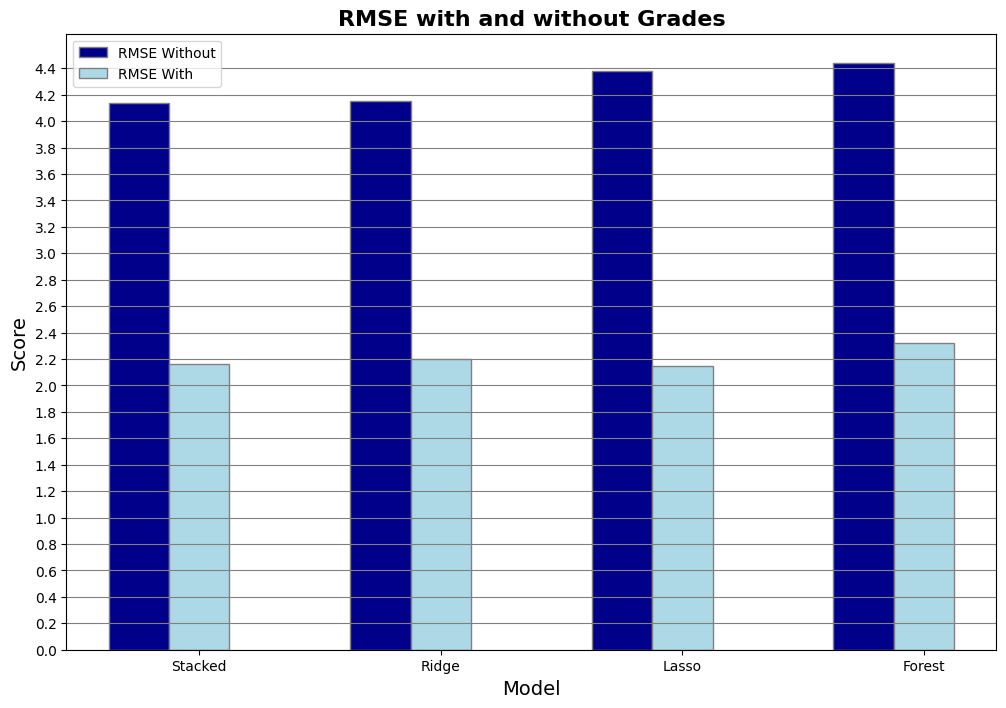

In [404]:

# stacking without: r2 = 0.16403862932757007, RMSE = 4.140220697005828

# Random Forest without: R2 = 0.040633420496280714, RMSE = 4.435296727404671

# Lasso without: R2 = 0.06612579032506105, RMSE = 4.3759724418479164

# Ridge without: R2 = 0.16037362095203167, RMSE = 4.1492865157631265


# stacking with: R2 = 0.7720651714307929, RMSE = 2.1619006530944285

# random forest with: R2 = 0.7385443972118901, RMSE = 2.3154177795099713

# lasso with: R2 = 0.7746532652027724, RMSE = 2.149591926092366

# ridge with: R2 = 0.7649979387482997, RMSE = 2.195160216034142


barWidth = 0.25
fig = plt.subplots(figsize =(12, 8)) 
plt.title('RMSE with and without Grades', fontweight ='bold', fontsize=16)
RMSE_without = [4.14, 4.15, 4.38, 4.44] 
RMSE_with = [2.16, 2.2, 2.15, 2.32] 

br1 = np.arange(len(RMSE_without)) 
br2 = [x + barWidth for x in br1] 

plt.bar(br1, RMSE_without, color ='darkblue', width = barWidth, 
        edgecolor ='grey', label ='RMSE Without') 
plt.bar(br2, RMSE_with, color ='lightblue', width = barWidth, 
        edgecolor ='grey', label ='RMSE With') 

plt.xlabel('Model', fontsize = 14) 
plt.ylabel('Score', fontsize = 14) 
plt.yticks(np.arange(0, 4.5, 0.20))
plt.grid(axis='y', color = 'gray')
plt.xticks([r + barWidth for r in range(len(RMSE_without))], 
        ['Stacked', 'Ridge', 'Lasso', 'Forest'])

plt.legend()
plt.show() 


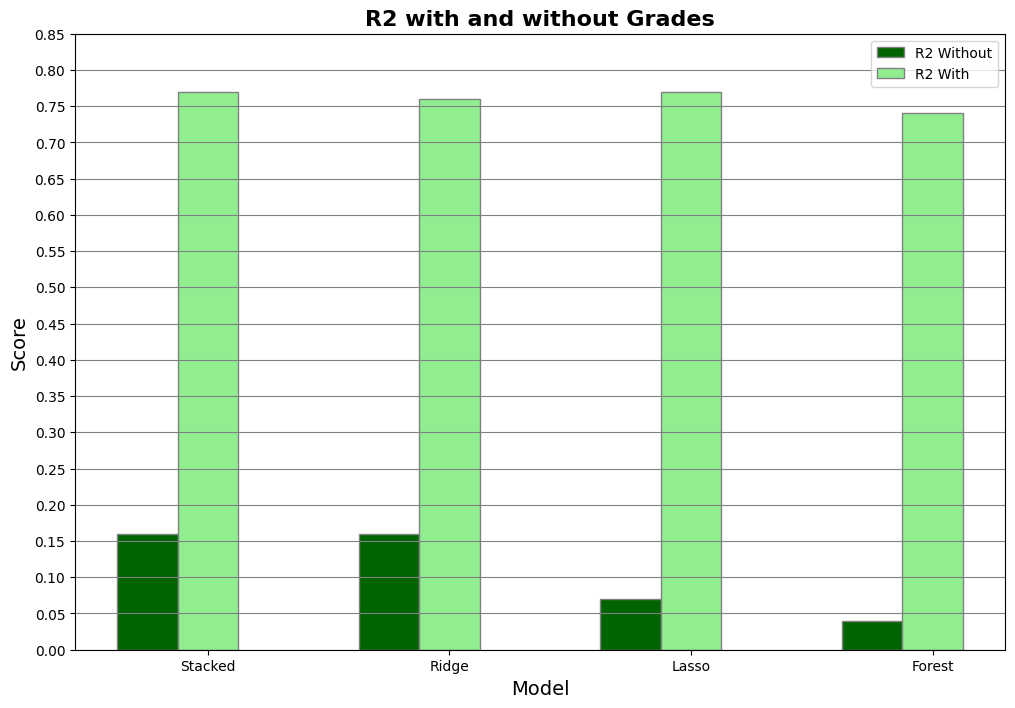

In [410]:
# stacking without: r2 = 0.16403862932757007, RMSE = 4.140220697005828

# Random Forest without: R2 = 0.040633420496280714, RMSE = 4.435296727404671

# Lasso without: R2 = 0.06612579032506105, RMSE = 4.3759724418479164

# Ridge without: R2 = 0.16037362095203167, RMSE = 4.1492865157631265


# stacking with: R2 = 0.7720651714307929, RMSE = 2.1619006530944285

# random forest with: R2 = 0.7385443972118901, RMSE = 2.3154177795099713

# lasso with: R2 = 0.7746532652027724, RMSE = 2.149591926092366

# ridge with: R2 = 0.7649979387482997, RMSE = 2.195160216034142


barWidth = 0.25
fig = plt.subplots(figsize =(12, 8)) 
plt.title('R2 with and without Grades', fontweight ='bold', fontsize=16)
R2_without = [0.16, 0.16, 0.07, 0.04] 
R2_with = [0.77, 0.76, 0.77, 0.74] 

br1 = np.arange(len(R2_without)) 
br2 = [x + barWidth for x in br1] 

plt.bar(br1, R2_without, color ='darkgreen', width = barWidth, 
        edgecolor ='grey', label ='R2 Without') 
plt.bar(br2, R2_with, color ='lightgreen', width = barWidth, 
        edgecolor ='grey', label ='R2 With') 

plt.xlabel('Model', fontsize = 14) 
plt.ylabel('Score', fontsize = 14) 
plt.yticks(np.arange(0, 0.9, 0.05))
plt.grid(axis='y', color = 'gray')
plt.xticks([r + barWidth for r in range(len(R2_without))], 
        ['Stacked', 'Ridge', 'Lasso', 'Forest'])

plt.legend()
plt.show() 

**Discussion**
The models with grades are decent. They can predict the grades within a couple points. The point scales are 0-20 so 2 points is a more significant difference than a 0-100 grading scale, but they still have decently strong prediction ability.

The models without grades are not nearly as helpful. The stacked model is the best, but even this 


None of the models are great, especially without the grades from G1 and G2. However, the Lasso model is the best option, though as shown in the final 
code block it is only marginally better than the svm best model option.
In addition, the R2 for the Lasso and SVM with grades is fairly good even though the root mean square error is high.